In [673]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import dual_annealing
import scipy as scipy
from scipy.spatial import KDTree, distance
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance_matrix
import json
# graph representation
import networkx as nx
# Pulser imports
import pulser as pulser
from pulser import Pulse, Sequence, Register
from pulser_simulation import SimConfig, QutipEmulator
from pulser import Pulse, Sequence, Register
from pulser.devices import AnalogDevice
from pulser.waveforms import RampWaveform, ConstantWaveform
from pulser.channels.dmm import DMM

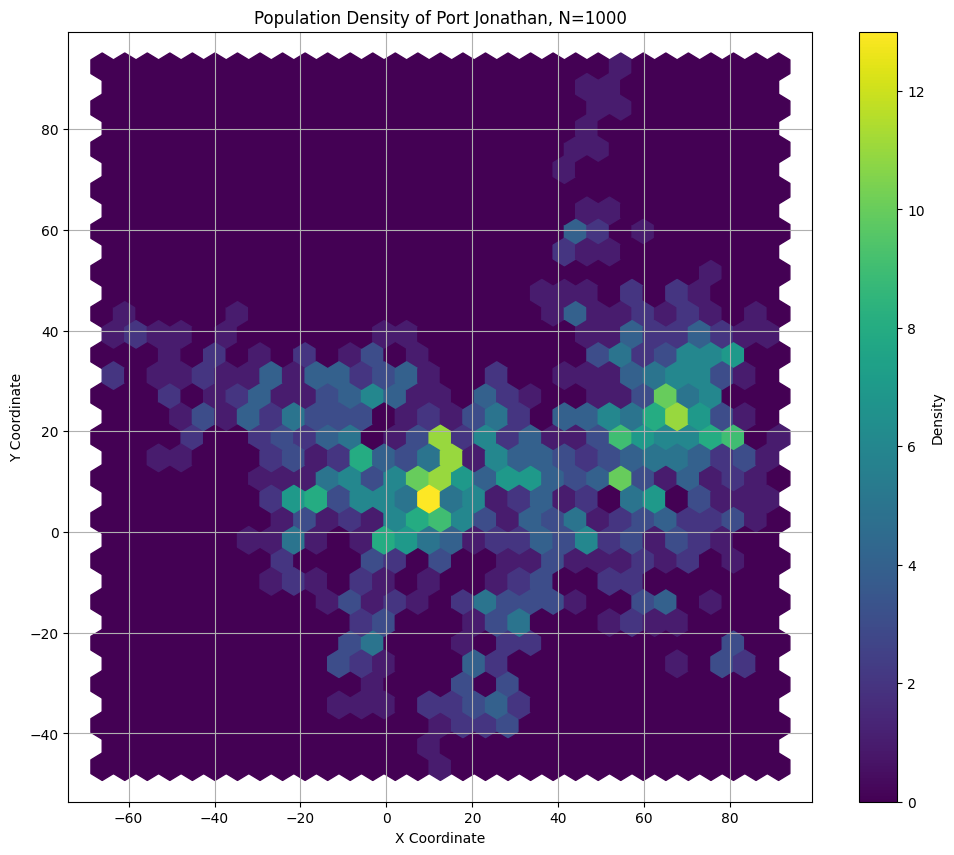

In [674]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[7]

with open('./data/population_{}.json'.format(city_name), 'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])
plt.figure(figsize=(12, 10))
plt.hexbin(x, y, gridsize=30, cmap='viridis')
#plt.hist2d(x, y, bins=30, cmap='viridis')
plt.colorbar(label='Density')

# Add titles and labels
plt.title('Population Density of {}, N={}'.format(city_name, len(x)))
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

In [675]:
def evaluate_coverage_final(population_x, population_y, placement, R_dist):
    x = population_x
    y = population_y
    B = len(x)
    coords = np.array([[x[i], y[i]] for i in range(len(x))])
    cost = 0
    for i in range(len(placement)):
        coord_i = np.array([placement[i]])
        for j in range(len(placement)):
            coord_j = np.array([placement[j]])
            if i != j:
                dist = scipy.spatial.distance.cdist(coord_i, coord_j)
                if dist < (2 + 1e-3)*R_dist:
                    cost += -B


        dist = scipy.spatial.distance.cdist(coord_i, coords)
        cov = np.sum(dist < R_dist)
        cost += cov

    if cost < 0:
        return -np.inf
    else:
        return cost
    
def simple_coverage(population_x, population_y, grid_points, R_antennas):
    cost = 0
    coords = np.array([[population_x[i], population_y[i]] for i in range(len(population_x))])
    for i in range(len(grid_points)):
        start = np.array(grid_points[i])
        dist = scipy.spatial.distance.cdist(np.array([start]), coords)
        truth_table = (dist <= R_antennas)
        cov = np.sum(truth_table)
        if cov == 0:
            cost -= len(population_x)/2
        cost += cov
    return cost
    

In [676]:
# Define parameters
population_x = x
population_y = y
offset = [population_x.min(), population_y.min()]  # Offset to start grid at (0, 0)
R_antennas = 25  # Operating radius for each antenna
spacing = R_antennas / 1.05  # Use a small spacing for high precision

max_grid_points = 8 # Maximum number of antennas


# This will become the cost function. Need to be checked carefully and written well for readability

In [677]:
def select_points_with_min_distance(grid_points, min_dist):
    # Convert grid points to a numpy array if it’s not already
    grid_points = np.array(grid_points)
    
    # Calculate pairwise distances between grid points
    distances = distance_matrix(grid_points, grid_points)
    
    # Initialize a list to hold the indices of selected points
    selected_indices = []
    
    # Keep track of points that can still be selected
    available_indices = set(range(len(grid_points)))
    
    while available_indices:
        # Select the first available point and add it to the selected list
        current_index = available_indices.pop()
        selected_indices.append(current_index)
        
        # Find all points within min_dist of the current point
        close_points = np.where(distances[current_index] < min_dist)[0]
        
        # Remove these points from the available set
        available_indices.difference_update(close_points)
    
    # Gather the selected points based on indices
    selected_points = grid_points[selected_indices]
    
    return selected_points


In [678]:
best_score = -1
list_best_grid_points = []
list_best_mis = []
list_best_coverage = []

def best_score_of_graph(grid_points, population_x, population_y, R_antennas, max_grid_points):
    global best_score
    global list_best_grid_points
    global list_best_mis
    global list_best_coverage
    # Store the MIS nodes for the final solution
    penalty = 0
    device_used = pulser.devices.MockDevice
    # Reshape positions array into (num_points, 2) format
    grid_points = grid_points.reshape((max_grid_points, 2))
    # create an UD graph embedding using appropriate coordinates
    coords = np.array(grid_points)
    val = np.min(pdist(coords))
    if val < 0.9*R_antennas:
        grid_points = select_points_with_min_distance(grid_points, 0.9*R_antennas)
        penalty -= np.abs(max_grid_points - len(grid_points)) * len(population_x)
        penalty = 0
        max_grid_points = len(grid_points)
        print(f'--- New number of antennas: {max_grid_points}')
        coords = np.array(grid_points)
        val = np.min(pdist(coords))
    factor = 5/val
    coords = coords*factor # Normalize to 5 b.c. minimum distance on real NAQC is around 4um
    # set Rabi frequency and detunind 
    # Parameters in rad/µs and ns
    omega_max = 2 * np.pi
    delta_0 = -6 * omega_max
    delta_f = 2 * omega_max
    t_rise = 252
    t_fall = 500
    t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 1000
    rydberg_radius = device_used.rydberg_blockade_radius(omega_max)
    R_antennas = 25*factor
    factor_for_rydberg_scaling = rydberg_radius/(2*R_antennas)
    R_antennas = R_antennas * factor_for_rydberg_scaling
    coords = coords * factor_for_rydberg_scaling
    # interaction coefficients U_ij
    Q = squareform(device_used.interaction_coeff / pdist(coords)**6)
    #np.fill_diagonal(Q, -z_coverage) #putting the weights
    # Noise confihuration
    noise_config = {
        "noiseless": None,
        "noisy": SimConfig(
            noise = ("SPAM", "dephasing", "doppler"),
            eta = 0.8,
            temperature = 1000,
            runs = 50,
        )
    }

    val = np.min(pdist(coords))
    qubits = dict(enumerate(coords))
    reg = Register(qubits)


    # number of segment for the detuning
    detunings_number = 5
    # number of time intervals for the detuning
    time_interval_number = 2*detunings_number - 3
    # Initial guess for the parameters 
    init_t_omega = np.array([250, 500])
    init_detuning_values = np.linspace(delta_0, delta_f, detunings_number)
    init_detuning_times = np.array([300]*time_interval_number)
    # Flatten and concatenate all parameters into a one-dimensional array
    initial_guess = init_t_omega.tolist() + init_detuning_values.tolist() + init_detuning_times.tolist()

    t_omega_param = initial_guess[0:2]
    detuning_values_param = initial_guess[2:2+detunings_number]
    detuning_times_param = initial_guess[2+detunings_number:]

    parametrized_sequence = create_sequence(omega_max, reg, device_used, len(detuning_values_param), len(detuning_times_param))
    # build the sequence
    sequence = parametrized_sequence.build(
        t_omega=t_omega_param,
        detuning_times = detuning_times_param, 
        detuning_values = detuning_values_param,
        )
    simulator = QutipEmulator.from_sequence(
        sequence, 
        sampling_rate=0.1,
        with_modulation = False,
        config=noise_config["noiseless"],
    )
    results = simulator.run(progress_bar=False)
    count_dict = results.sample_final_state(N_samples=10000)

    most_frequent = {k:v for k,v in count_dict.items() if v>10}
    solution = [key for key, value in sorted(most_frequent.items(), key=lambda item: item[1], reverse=True)]

    max_iter = len(solution) if len(solution) < 6 else 6
    real_R = 25
    coverage = -1 #initialize with negative to check whether these solutions are IS or not
    best_coverage_index = 0 #again to check IS
    for i in range(max_iter):
        selected_nodes = convert_to_indices(solution[i])
        solution_i_points = [grid_points[j] for j in selected_nodes]
        if(len(solution_i_points)==0): continue
        coverage_i = simple_coverage(population_x, population_y, solution_i_points, real_R)
        ## Check if the node set is an independent set
        check = KDTree(solution_i_points).query_pairs(2*real_R)
        if len(check)>0: #if any pair is closer than real_R, not independent, skip that solution
            continue

        if coverage_i > coverage:
            coverage = coverage_i
            best_coverage_index = i

    try:
        best_solution_indices = convert_to_indices(solution[best_coverage_index])
        best_solution_points = [grid_points[j] for j in best_solution_indices]
        best_solution_z_coverage = simple_coverage(population_x, population_y, best_solution_points, real_R)

        # only keep antennas with coverage at least 10
        global final_solution_indices
        #final_solution_indices = [best_solution_indices[i] for i in range(len(best_solution_z_coverage)) if best_solution_z_coverage[i]>10] 
        final_solution_indices = best_solution_indices

        if coverage > best_score:
            print(f'New best coverage: {coverage}')
            best_score = coverage
            list_best_grid_points.append(grid_points)
            list_best_mis.append(final_solution_indices)
            list_best_coverage.append(best_solution_z_coverage)
        
        print(f'Coverage: {coverage}')
        print(f'Coverage + penalty: {coverage + penalty}')
        print(f'Best Coverage: {best_score}')
        return - (coverage + penalty)
    except:
        return 100

In [679]:
def create_pulse(Omega_max, t_omega, detuning_values, detuning_times, time_interval_number):
    # Create Pulse
    list_pulses = []
    # 1. rise to omega_max with 0 detuning
    rabi_t_rise, rabi_t_fall = t_omega
    list_pulses.append(Pulse.ConstantDetuning(
        amplitude=RampWaveform(rabi_t_rise, 0, Omega_max), 
        detuning=detuning_values[0], 
        phase=0)
        )
    # 2. Rampwaveforms from \Delta_{min} to \Delta_{max} with constant Omega_max
    counter = 0
    for i in range(time_interval_number):
        if i % 2 ==0:
            list_pulses.append(Pulse.ConstantAmplitude(
                amplitude=Omega_max, 
                detuning=RampWaveform(detuning_times[i], detuning_values[counter], detuning_values[counter+1]),
                phase=0
                ))
            counter += 1
        else:
            list_pulses.append(Pulse.ConstantAmplitude(
                amplitude=Omega_max, 
                detuning=ConstantWaveform(detuning_times[i], detuning_values[counter]),
                phase=0
                ))
    # 3. fall to 0 with \Delta_f detuning
    list_pulses.append(Pulse.ConstantDetuning(
        amplitude=RampWaveform(rabi_t_fall, Omega_max, 0), 
        detuning=detuning_values[-1], 
        phase=0)
        )
    return list_pulses
   

In [680]:
def create_sequence(omega_max, register, device_used, detunings_number, time_interval_number):
    # parametrized sequence
    parametrized_sequence = Sequence(register, device_used)
    parametrized_sequence.declare_channel("rydberg", "rydberg_global")
    # time to ramp to Maximum Rabi Frequency and time to ramp to 0
    t_omega = parametrized_sequence.declare_variable("t_omega", size=2, dtype=int)
    # detunings values
    detuning_values = parametrized_sequence.declare_variable("detuning_values", size=detunings_number, dtype=float)
    # detuning times intervals
    detuning_times = parametrized_sequence.declare_variable("detuning_times", size=time_interval_number, dtype=int)

    # Create Pulse
    list_pulses = create_pulse(omega_max, t_omega, detuning_values, detuning_times, time_interval_number)

    # create sequence
    for i in range(len(list_pulses)):
        parametrized_sequence.add(list_pulses[i], "rydberg")
    return parametrized_sequence


In [681]:
# Function to convert a bitstring to a list of node indices included in the set
def convert_to_indices(bitstring):
    return [i for i, bit in enumerate(bitstring) if bit == '1']

def generate_triangular_grid(side_lengths, spacing, offset, maximum_points):
    rows, cols = side_lengths
    points = []
    counter = 0
    for row in range(rows):
        for col in range(cols):
            if (counter >= maximum_points):
                break
            # Calculate the x coordinate
            x = col * spacing
            # Offset every other row by half the side length
            if row % 2 == 1:
                x += spacing / 2
            # Calculate the y coordinate based on the row number
            y = row * (spacing * (3**0.5) / 2)  # Height of an equilateral triangle
            points.append([x + offset[0], y + offset[1]])
            counter += 1
    return points 

In [683]:
# Define Initial grid
population_x = x
population_y = y
offset = [population_x.min(), population_y.min()]  # Offset to start grid at (0, 0)
R_antennas = 25  # Operating radius for each antenna
#run simmulated annealing
bounds_offset_x = np.abs(population_x.max()-population_x.min())/10
bounds_offset_y = np.abs(population_y.max()-population_y.min())/10
bounds=[(population_x.min()-bounds_offset_x, population_x.max()+bounds_offset_x)] * max_grid_points + [(population_y.min()-bounds_offset_y, population_y.max()+bounds_offset_y)] * max_grid_points

best_score = -1
list_best_grid_points = []
list_best_mis = []
list_best_coverage = []

result = dual_annealing(
    func=best_score_of_graph,
    args=(population_x, population_y, R_antennas, max_grid_points),
    bounds=bounds,
    initial_temp=100.0,           # Default: 5230.0. Sets the initial temperature. Lower values lead to more conservative (smaller) moves initially
    restart_temp_ratio=1e-6,     # Default: 2e-5. Determines the temperature ratio at which to restart the annealing process
    visit=1.5,                    # Default: 2.62. Controls the "visiting" distribution, which impacts the step size for each move. Lower values reduce step size, leading 
                                  # to smaller, more conservative moves that can help fine-tune around the current solution
    accept=-1.0,                  # Default: -5.0. Controls the acceptance distribution, affecting the 
                                  # probability of accepting worse solutions. Less negative values make the acceptance criteria stricter
    maxfun=400,                  # Default: 1e7. Maximum number of function evaluations 
    no_local_search=True,         # Default: False. When True, disables the local search phase at the end 
    seed=42,                       # Default: None. Sets a random seed for reproducibility
)
#initial_temp=500,
#visit=1.6,

Coverage: -1
Coverage + penalty: -1
Best Coverage: -1
Coverage: -1
Coverage + penalty: -1
Best Coverage: -1
--- New number of antennas: 6
Coverage: -1
Coverage + penalty: -1
Best Coverage: -1
--- New number of antennas: 6
Coverage: -1
Coverage + penalty: -1
Best Coverage: -1
--- New number of antennas: 5
Coverage: -1
Coverage + penalty: -1
Best Coverage: -1
--- New number of antennas: 6
Coverage: -1
Coverage + penalty: -1
Best Coverage: -1
--- New number of antennas: 6
Coverage: -1
Coverage + penalty: -1
Best Coverage: -1
--- New number of antennas: 6
New best coverage: 41
Coverage: 41
Coverage + penalty: 41
Best Coverage: 41
New best coverage: 366
Coverage: 366
Coverage + penalty: 366
Best Coverage: 366
--- New number of antennas: 7
Coverage: -1
Coverage + penalty: -1
Best Coverage: 366
--- New number of antennas: 7
Coverage: -1
Coverage + penalty: -1
Best Coverage: 366
--- New number of antennas: 7
Coverage: 334
Coverage + penalty: 334
Best Coverage: 366
--- New number of antennas: 6

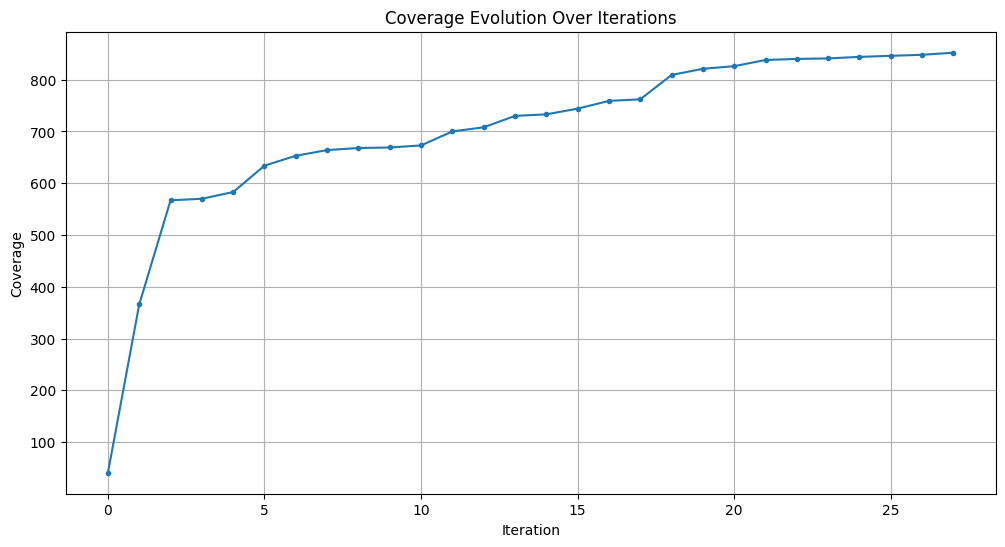

In [684]:
# Plot the evolution of the coverage over iterations
plt.figure(figsize=(12, 6))
plt.plot(range(len(list_best_coverage)), list_best_coverage, marker='.')
plt.xlabel('Iteration')
plt.ylabel('Coverage')
plt.title('Coverage Evolution Over Iterations')
plt.grid(True)
plt.show()

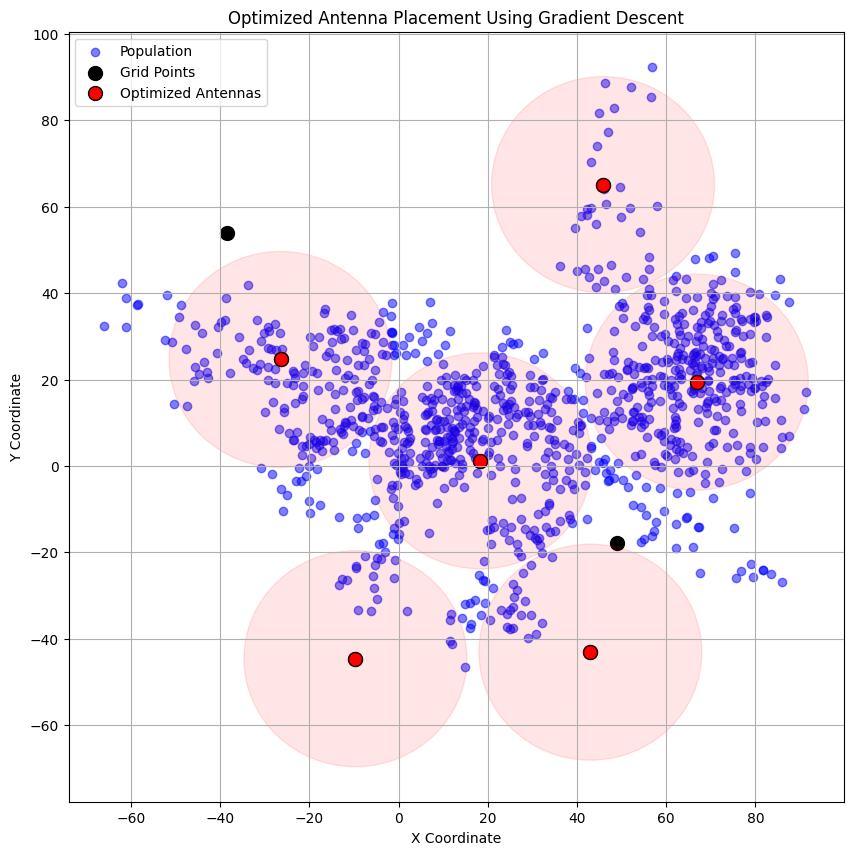

Final coverage: 852
Real coverage: 852 out of 1000


In [685]:
# Extract the positions of the MIS nodes
best_grid_points = list_best_grid_points[-1]
best_mis = list_best_mis[-1]
final_positions = best_grid_points[best_mis]

# Plot the optimized grid and population
plt.figure(figsize=(10, 10))
plt.scatter(population_x, population_y, c='blue', label='Population', alpha=0.5)
plt.scatter(best_grid_points[:, 0], best_grid_points[:, 1], c='black', label='Grid Points', s=100, edgecolors='black')
plt.scatter(final_positions[:, 0], final_positions[:, 1], c='red', label='Optimized Antennas', s=100, edgecolors='black')

for pos in final_positions:
    circle = plt.Circle((pos[0], pos[1]), R_antennas, color='red', alpha=0.1)
    plt.gca().add_patch(circle)

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Optimized Antenna Placement Using Gradient Descent')
plt.legend()
plt.grid(True)
plt.show()

score = evaluate_coverage_final(population_x, population_y, final_positions, R_antennas)
print('Final coverage:', score)
real_coverage = simple_coverage(population_x, population_y, final_positions, R_antennas)
print(f'Real coverage: {real_coverage} out of {len(population_x)}')